# Exploring Agglomerative Clustering
Author: Tristan Miller

I originally intended to make a validation measure for agglomerative clustering, but a lot of this is just exploring so far.

### Initialization
Here I'm just copying code from a bunch of other notebooks

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import *
import scipy
from sklearn.decomposition import PCA
#import lda #use pip install lda 
import time
from sklearn.cluster import AgglomerativeClustering
import sys
import re
import wikipedia #use pip install wikipedia
from scipy.spatial.distance import euclidean

In [2]:
#Load data, document-term matrix
data = pd.read_pickle("processed_10k_articles.pkl")
unweighted_words = np.reshape(np.load("document_term_matrix.npy"),(1))[0]
term_list = pd.read_pickle("term_list.pkl")[0].tolist()

In [3]:
#Cap the word frequency at 10.
#This is necessary at least for now with all those list articles
tens = np.zeros(unweighted_words.shape)+10
unweighted_words = scipy.sparse.csr_matrix(np.minimum(unweighted_words.toarray(),tens))

In [4]:
#Apply TF-IDF weighting
Tfidf = TfidfTransformer()
Tfidf.fit(unweighted_words)
weighted_words = Tfidf.transform(unweighted_words)

In [5]:
#Apply PCA with 30 components
start_time = time.time()
model = PCA(n_components=30)
doc_topic = model.fit_transform(weighted_words.toarray())
topic_word = model.components_
processing_time = (time.time() - start_time)/60
print("Time to execute: %.2f minutes" % processing_time )

Time to execute: 0.01 minutes


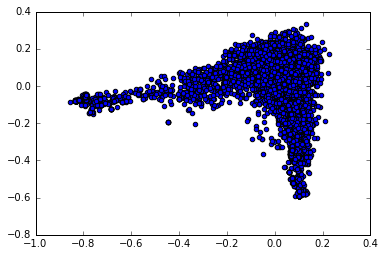

In [6]:
%matplotlib inline
plt.scatter(doc_topic[:,0], doc_topic[:,1])

In [7]:
#Ward Agglomerative clustering
start_time = time.time()
clustering = AgglomerativeClustering(linkage="ward", n_clusters=20)
c_labels = clustering.fit_predict(doc_topic)
processing_time = (time.time() - start_time)/60
print("Time to execute: %.2f minutes" % processing_time )

Time to execute: 3.05 minutes


In [8]:
#Vectorize the links too
#links need to be put into the proper format
links = data["links"].copy()
for i in range(len(links)):
    for j in range(len(links[i])):
        links[i][j] = re.sub(' ','_',links[i][j])
for i in range(len(links)):
    links[i] = " ".join( links[i] )

In [70]:
vectorizer = CountVectorizer(analyzer = "word",min_df=.005)
link_vector = vectorizer.fit_transform(links)
link_names = vectorizer.get_feature_names()
link_vector.shape

(10000, 386)

In [71]:
#Take underscores out from link_names
for i in range(len(link_names)):
    link_names[i] = re.sub('_',' ',link_names[i])

## Understanding the clustering

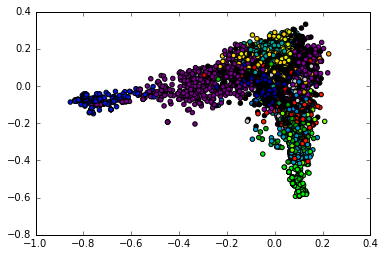

In [23]:
plt.scatter(doc_topic[:, 0], doc_topic[:, 1], c=c_labels,
                        cmap=plt.cm.spectral)

In [24]:
children = clustering.children_
print("Labels of first 20 articles:",c_labels[0:20])
print("First 20 nodes:",children[0:20])

Labels of first 20 articles: [2 2 2 0 2 2 2 2 0 0 0 2 0 0 2 2 2 2 2 0]
First 20 nodes: [[ 1778  1779]
 [ 1811  1812]
 [ 1823 10001]
 [ 1833 10002]
 [ 1882 10003]
 [ 1879  1935]
 [ 1883 10004]
 [ 1887 10006]
 [ 1885  1996]
 [ 1888 10007]
 [ 1889 10009]
 [ 1890 10010]
 [ 1891 10011]
 [ 1893 10012]
 [ 1895 10013]
 [ 1908 10014]
 [ 1909 10015]
 [ 1913 10016]
 [ 1925 10017]
 [ 1934 10018]]


What's this all mean?

Apparently, children[x] is the xth node in the tree.  There are 9999 nodes, which is 1 less than the number of documents in the tree.  Documents are not themselves nodes, but rather the leaves of the tree.

children[children[x][0]-10000] is the left child of the xth node, and children[children[x][1]-10000] is the right child.  If children[x][y] is less than 10000 (the number of documents), then the child referred to is not another node, but document number children[x][y]

After making a tree, the algorithm somehow selects N clusters from it.  Cluster number 0 is obviously the biggest cluster

### Translating the tree
The above format is a really counterintuitive way to think about trees, so I'm translating it to a better format.

In [136]:
if 'cluster_tree' in sys.modules:
    del sys.modules['cluster_tree'] #this just makes sure the import updates every time
from cluster_tree import *

In [26]:
#I wrote a TreeNode class, and translated the output of the clustering to it
root = tree_to_nodes(children,10000)

In [27]:
#Now I can classify each leaf
classified_tree = classify_tree(root,c_labels)
#And produce a reduced tree that only shows the clusters relative to each other
label_tree = get_label_tree(classified_tree)

In [28]:
str(label_tree)

'((4,1),(11,(((12,(6,8)),(9,(16,(18,5)))),(((15,2),(10,((19,3),(14,(17,0))))),(13,7)))));'

In [29]:
#pip install ete3
#this is from here: http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html
from ete3 import Tree, TreeStyle
t = Tree(str(label_tree))
ts = TreeStyle()
ts.show_leaf_name = True
ts.scale =  12
t.show(tree_style=ts)
#output is in a different window.

# Allowing more than 2 children per node
The problem with the agglomerative clustering algorithms is that they produce *binary* trees, where each node has two children.  Intuitively, a topic may sometimes have more than two subtopics.

We need two things:
1. A way to collapse a non-leaf node with a non-leaf child.  That is, go from (A,(B,C)) to (A,B,C).
2. An algorithm that finds all times when this is appropriate.

Intuitively, (A,(B,C)) should be converted to (A,B,C) when A,B, and C are about equidistant from each other.  Although it's possible that A,B, and C are collinear.  So the condition would be dist(B,C) ~> dist(A,B) OR dist(B,C) ~> dist(A,C).

More generally, we might have a branch that looks like (A,B,(C,D,E)).  grandchild_separation is the smallest distance between any pairs of C,D,E.  child_separation is the smallest distance between any pair, where one of the pair is taken from (A,B), and the other of the pair is taken from (C,D,E).  The branch is collapsed to (A,B,C,D,E) if grandchild_separation ~> child_separation.

Now all we need to do is define the "dist" and "~" operations.  As a first attempt, I will define "dist" as the distance between means of the clusters.  "~" will be defined as having a given tolerance

In [72]:
#Get all cluster means.
(cm,docs_in_cluster) = get_means(c_labels,doc_topic)
(link_means,docs_in_cluster) = get_means(c_labels,link_vector)

In [31]:
#now let's apply the algorithm described above, with zero tolerance
collapsed_tree = collapse_label_tree(label_tree,cm,docs_in_cluster,0)
str(collapsed_tree)

'(1,4,(9,18,5,16,12,8,6,13,7,(2,15,17,0,14,19,3,10)),11);'

In [32]:
t = Tree(str(collapsed_tree))
t.show(tree_style=ts)

This seems to collapse the tree too much.  We can always give it a negative tolerance to collapse it less

In [33]:
collapsed_tree = collapse_label_tree(label_tree,cm,docs_in_cluster,-.21)
str(collapsed_tree)

'(1,4,((16,5,18),9,(12,(6,8)),13,7,(2,15,((19,3),(14,(17,0))),10)),11);'

In [34]:
t = Tree(str(collapsed_tree))
t.show(tree_style=ts)

## Summary so far
Ward Agglomerative Clustering places all documents in a giant binary tree.  It then creates N clusters by picking various branches of the tree.  This not only classifies each document into one of N clusters, it also creates a topic tree, with the N clusters as its leaves.

The problem with this topic tree is that it is a binary tree.  However, it is relatively to collapse this tree so that it is no longer restricted to being binary.  The end result is a topic tree, with both "internal node" topics, and "leaf" topics.  Each document is classified within one of the leaves.

Of course, we still need to select the number of leaves, and it's possible that the algorithm for collapsing can be improved.  For these, we need a validation measure.

## Describing a cluster
After we've created the clusters, we'd like to describe them.  This could involve: A) Making a word cloud, and B) finding a representative article

In [35]:
#pip install wordcloud
#see example here: https://github.com/amueller/word_cloud/blob/master/examples/simple.py
#Windows machines have trouble doing this installation, so maybe someone else should do this one.
from wordcloud import WordCloud
testcloud = WordCloud().generate('hello world')

ImportError: No module named 'wordcloud'

There are multiple ways to generate the top words/articles for a cluster:
1. Use doc_topic and topic_word matrices together
2. Just use the weighted_words matrix
3. Look at the links

In [38]:
#this function takes a cluster mean, and generates a list of the top words
def words_from_branch(c_mean,term_list,topics=None):
    #If topic_word is given, then it's assumed that c_mean is in topic space
    #and topic_word is used to translate topic space to word space.
    if(topics is not None):
        bag = np.dot(c_mean,topics)
    else:
        bag = c_mean
    df = pd.DataFrame(index=range(len(bag)),columns=['Term','Weight'])
    df['Term'] = term_list
    df['Weight'] = bag
    df.sort_values('Weight',ascending=False,inplace=True)
    return df


In [39]:
c_mean,documents = get_branch_mean(collapsed_tree[2][3],cm,docs_in_cluster)
words_from_branch(c_mean,term_list,topics=topic_word).head()

,Term,Weight
7,album,0.310510
323,song,0.196169
282,releas,0.163774
32,band,0.153699
317,singl,0.096806


In [73]:
#I can also find the most common links in a cluster
l_mean,documents = get_branch_mean(collapsed_tree[2][3],link_means,docs_in_cluster)
words_from_branch(l_mean,link_names).head()

,Term,Weight
117,album,0.700272
338,song,0.444142
137,band,0.403270
250,magazine,0.283379
370,united states,0.256131


In [133]:
a = np.array([1,5,3])
a.argmax()

1

In [137]:
#now generate a tree from top links
#I wrote the algorithm so that it favors links *not* used by neighboring branches
#It also assigns names to each internal node, although I don't know how to show that using the ete3 package
link_tree = get_name_tree(collapsed_tree,link_means,docs_in_cluster,link_names)

In [138]:
print(link_tree)

(ice hockey,association football,((city,river,village), florida,(district,(sweden,belgium)),album,movie,(chemistry,animal,((united states,footballer),(movie,(university, new york))),video game)),saint);


Eh, maybe it will look better when we use regular wikipedia and limit to just the intros.
Later, we may also want to name each branch, making sure to give them names that distinguish them from adjacent branches

## Classifying a new article
Once the classification is done, we also want to be able to classify a new article.

A string of words can be generated from the wikipedia package.  For instance:

In [87]:
wikipedia.summary('One Direction')

'One Direction (commonly abbreviated as 1D) are an English-Irish pop boy band based in London, composed of Niall Horan, Liam Payne, Harry Styles, Louis Tomlinson, and previously, Zayn Malik until his departure from the band on 25 March 2015. The group signed with Simon Cowell\'s record label Syco Records after forming and finishing third in the seventh series of the British televised singing competition The X Factor in 2010. Propelled to international success by social media, One Direction\'s four albums, Up All Night (2011), Take Me Home (2012), Midnight Memories (2013) and Four (2014) topped charts in most major markets, and generated hit singles including "What Makes You Beautiful", "Live While We\'re Young", and "Story of My Life". Their fifth studio album, Made in the A.M., was released in November 2015.\nTheir awards include six Brit Awards, four MTV Video Music Awards, eleven MTV Europe Music Awards, seven American Music Awards (including Artist of the Year in 2014 and 2015), an

There are some complications with using this package, but I think other members of the team are working on that.  For now, I'll assume that a string like the above is given.

In [126]:
#To classify an article, we need 5 things.
#The article text
#A list of the terms for vectorization
#The TF-IDF transformation
#The topic_word matrix from PCA analysis
#The means of the clusters in topic space
def classify_article(article_text,term_list,Tfidf,topic_word,c_means):
    vectorizer = CountVectorizer(analyzer = "word",vocabulary=term_list)
    article_vector = vectorizer.fit_transform([article_text])
    article_weighted = Tfidf.transform(article_vector).toarray()
    article_topic = np.dot(article_weighted,np.transpose(topic_word))
    #now calculate the closest cluster mean
    min_distance = np.inf
    for i in range(c_means.shape[0]):
        current_distance = euclidean(article_topic,c_means[i,:])
        if current_distance < min_distance:
            min_distance = current_distance
            closest_cluster = i
    
    return closest_cluster

In [127]:
cluster_id = classify_article(wikipedia.summary('One Direction'),term_list,Tfidf,topic_word,cm)
words_from_branch(cm[cluster_id,:],term_list,topics=topic_word).head()

,Term,Weight
7,album,0.310510
323,song,0.196169
282,releas,0.163774
32,band,0.153699
317,singl,0.096806
